# Semantic Similarities: Differences in distance among different sub-reddits
#### Benchmark is the askscience subreddit. An analysis in how far other subreddits (askmen, askwoman, democracts & republicans) deviate from this benchmark is conducted


In [113]:
import numpy as np
import pandas as pd


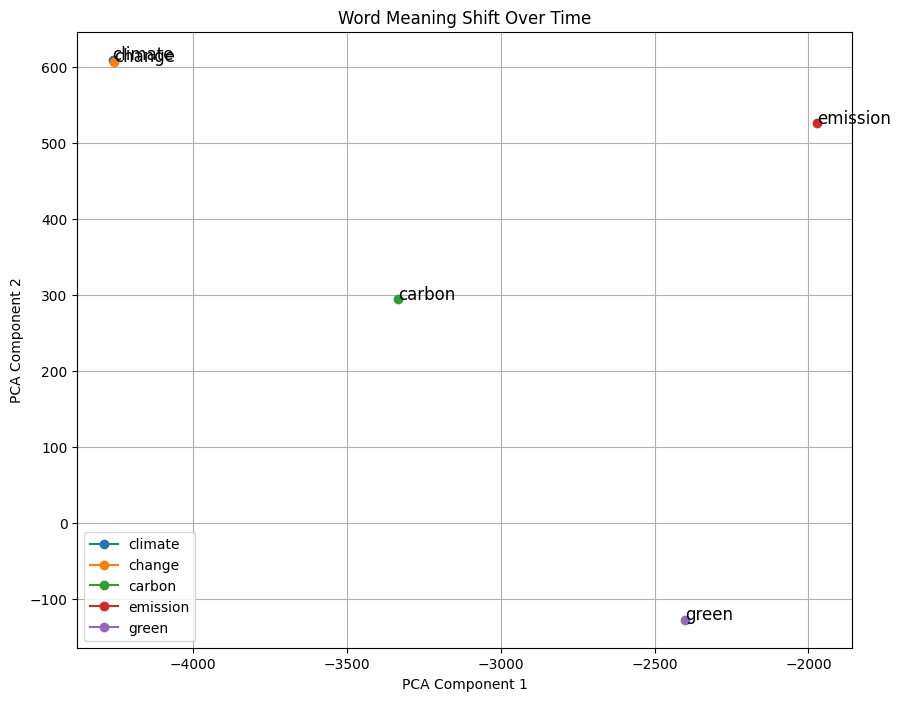

In [114]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Load the embeddings
years = list(range(2010, 2023))
embeddings = {}

for year in years:
    embeddings[year] = pd.read_csv(f'/Users/fabianmahner/dlss-project24/output/embeddings/embeddings_CBOW_posts_{year}.csv')

# Step 2: Align the words (ensure all embeddings have the same words)
words = set(embeddings[years[0]]['word'])
for year in years[1:]:
    words &= set(embeddings[year]['word'])

words = list(words)  # list of common words across all years

# Step 3: Concatenate the embeddings for each word across all years
all_embeddings = []

for year in years:
    df = embeddings[year]
    df = df[df['word'].isin(words)]
    all_embeddings.append(df.set_index('word').loc[words].values)

all_embeddings = np.concatenate(all_embeddings, axis=1)

# Step 4: Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_embeddings)

# Step 5: Visualize the results for a few selected words
selected_words = ['climate', 'change', 'carbon', 'emission', 'green']  # example words

plt.figure(figsize=(10, 8))

for word in selected_words:
    index = words.index(word)
    x = pca_result[index, 0::2]
    y = pca_result[index, 1::2]
    plt.plot(x, y, marker='o', label=word)
    plt.text(x[-1], y[-1], word, fontsize=12)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Word Meaning Shift Over Time')
plt.legend()
plt.grid(True)
plt.show()


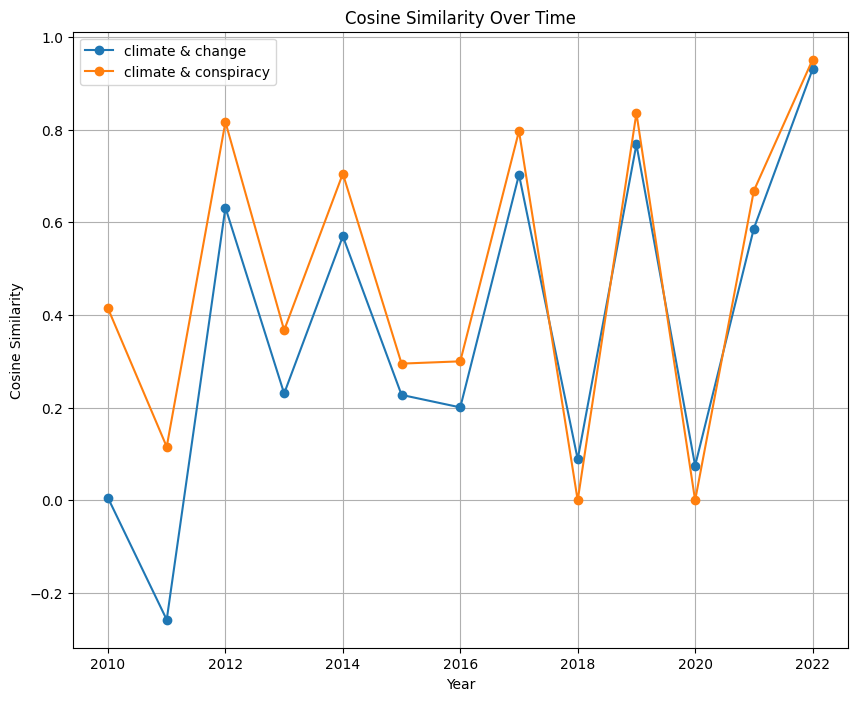

In [115]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Step 1: Load the embeddings
years = list(range(2010, 2023))
embeddings = {}

for year in years:
    embeddings[year] = pd.read_csv(f'/Users/fabianmahner/dlss-project24/output/embeddings/embeddings_CBOW_posts_{year}.csv')

# Step 2: Align the words
words = set(embeddings[years[0]]['word'])
for year in years[1:]:
    words &= set(embeddings[year]['word'])

words = list(words)  # list of common words across all years

# word pairs
word_pairs = [('climate', 'change'), ('climate', 'conspiracy')]  # example pairs

# Step 3: Calculate Cosine Similarity
similarities = {pair: [] for pair in word_pairs}

for year in years:
    df = embeddings[year]
    df = df[df['word'].isin(words)]
    word_vectors = df.set_index('word').loc[words]

    for word1, word2 in word_pairs:
        vec1 = word_vectors.loc[word1].values.reshape(1, -1)
        vec2 = word_vectors.loc[word2].values.reshape(1, -1)
        sim = cosine_similarity(vec1, vec2)[0][0]
        similarities[(word1, word2)].append(sim)

# Step 4: Visualize the Results
plt.figure(figsize=(10, 8))

for pair, sims in similarities.items():
    plt.plot(years, sims, marker='o', label=f"{pair[0]} & {pair[1]}")

plt.xlabel('Year')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [116]:
# subreddits 
# ask science
# alle 
# democracts vs
# republicans

# compare cosine similarity between subreddits
# 
# climate change relavante  wörter distance vergleichen zwischen ask science und democracts 
# 

In [117]:
# embeddings vergleichen

In [118]:
# hauptmodell mit benchmark modells: all words and only climate words 
